## 파일 정보
1. Lv1 : Binary Segmentation
2. Object : Roads
3. _Backbone - Efficientb3,  Model - U-net
4. preprocessing : Augmentation (HorizontalFlip, ShiftScaleRotate,RandomContrast,RandomGamma,RandomBrightness)
5. Active Learning : X
## 파라미터
1. Batch Size : 1
2. Learning Rate : 0.001
3. Epoch : 30
4. Beta1 : 0.9, Beta2 : 0.999

In [1]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 6.2MB/s 


In [2]:
!pip install wandb

     |████████████████████████████████| 1.8MB 4.0MB/s 
     |████████████████████████████████| 133kB 17.5MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 174kB 17.2MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=5323342d687c09476895262fc38eff994751f94b8335f350aea4b6b72cb4134f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=ffb8979df9d5bb7ddba6710e7e8437ac48cc08b5e0ee9ab1c6a6661d57b06dd0
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [3]:
import wandb

from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
wandb.init(project='segmentation models', entity='https-wandb-ai-jadenmun-res50_unet-workspace-user-jadenmun')


# 2. Save model inputs and hyperparameters
config = wandb.config
wandb.config.update({"image_size": 1024, # crop 했을 경우엔 crop 된 size
                     "learning_rate": 0.0001, 
                     "batch_size": 1, 
                     "epochs": 30,
                     "backbone": "efficientnetb3", "model" : "U-Net",
                     "class": "road", # ["building", "road", "mixed", "outline"]
                     "preprocess": "none", "augmentation": "none" , "image_patch": "none"  }) # ["none", "cropped"]
config = wandb.config


wandb: Currently logged in as: https-wandb-ai-jadenmun-res50_unet-workspace-user-jadenmun (use `wandb login --relogin` to force relogin)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import math
import os
import glob
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import tensorflow as tf

from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

In [7]:
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [8]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1 
LR = 0.0001
EPOCHS = 30
preprocess_input = sm.get_preprocessing(BACKBONE)

빌딩이냐 도로만 바꾸면됨 

In [9]:
train_input_DIR =  '/content/drive/MyDrive/SIA/roads/train/raw_image/' #input 경로

train_label_DIR = '/content/drive/MyDrive/SIA/roads/train/new_label/' #label 경로 

val_input_DIR =  '/content/drive/MyDrive/SIA/roads/val/raw_image/' #input 경로

val_label_DIR = '/content/drive/MyDrive/SIA/roads/val/new_label/' #label 경로 

In [10]:
train_input = glob.glob(train_input_DIR  + '*.png')
train_input.sort()
train_label  = glob.glob(train_label_DIR + '*.png')
train_label.sort()
val_input = glob.glob(val_input_DIR  + '*.png')
val_input.sort()
val_label  = glob.glob(val_label_DIR + '*.png')
val_label.sort()

In [11]:
CLASSES = ['roads']

In [12]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset_bi:
    CLASSES =  ['roads','buildings']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [i.split('/')[-1] for i in images_dir]
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.reshape(1024,1024,-1)

        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            # 둘다 1일 경우..
            background = 255 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            mask = np.where(mask == 255, mask, 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         image = image/255         
        mask = mask/255
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [13]:
train_dataset = Dataset_bi(

    train_input,train_label 
    ,
    classes=CLASSES,
#         preprocessing=get_preprocessing(preprocess_input),
)

In [14]:
valid_dataset = Dataset_bi(
    val_input, val_label,
    classes=CLASSES,    
#     augmentation=get_validation_augmentation(),
#         preprocessing=get_preprocessing(preprocess_input)

)

In [15]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset_bi:
    CLASSES =  ['roads','buildings']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [i.split('/')[-1] for i in images_dir]
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.reshape(1024,1024,-1)

        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            # 둘다 1일 경우..
            background = 255 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            mask = np.where(mask == 255, mask, 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         image = image/255         
        mask = mask/255
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [16]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
       
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [17]:
import albumentations as A

In [18]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(1024, 1024)
    ]
    return A.Compose(test_transform)


In [19]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [20]:
CLASSES =  ['roads']


## 모델 설계

In [21]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 2s 0us/step


In [22]:
# define optomizer
optim = keras.optimizers.Adam(LR,0.99,0.999)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [23]:
train_dataloader = Dataloder(train_dataset, batch_size= 1 , shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [24]:
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(), WandbCallback()
]


In [25]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f519211c590>>

In [26]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001_ch.h5', verbose=1, save_best_only=True)
# train model
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
     callbacks=[checkpointer,callbacks],      validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader) ,verbose = 1
)

Epoch 1/30
1144/1144 [==============================] - 3050s 3s/step - loss: 0.6125 - iou_score: 0.4061 - f1-score: 0.5533 - val_loss: 0.4877 - val_iou_score: 0.4768 - val_f1-score: 0.6231

Epoch 00001: val_loss improved from inf to 0.48766, saving model to /content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001_ch.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
1144/1144 [==============================] - 581s 508ms/step - loss: 0.4304 - iou_score: 0.5305 - f1-score: 0.6777 - val_loss: 0.4949 - val_iou_score: 0.4562 - val_f1-score: 0.6016

Epoch 00002: val_loss did not improve from 0.48766
Epoch 3/30
1144/1144 [==============================] - 580s 507ms/step - loss: 0.3748 - iou_score: 0.5755 - f1-score: 0.7179 - val_loss: 0.4541 - val_iou_score: 0.5045 - val_f1-score: 0.6454

Epoch 00003: val_loss improved from 0.48766 to 0.45409, saving model to /content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001_ch.h5
Epoch 4/30
1144/1144 [==============================] - 579s 506ms/step - loss: 0.3391 - iou_score: 0.6072 - f1-score: 0.7446 - val_loss: 0.4506 - val_iou_score: 0.4996 - val_f1-score: 0.6392

Epoch 00004: val_loss improved from 0.45409 to 0.45057, saving model to /content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001_ch.h5
Epoch 5/30
1144/1144 [==============================] - 580s 507ms/step - loss: 0.3131

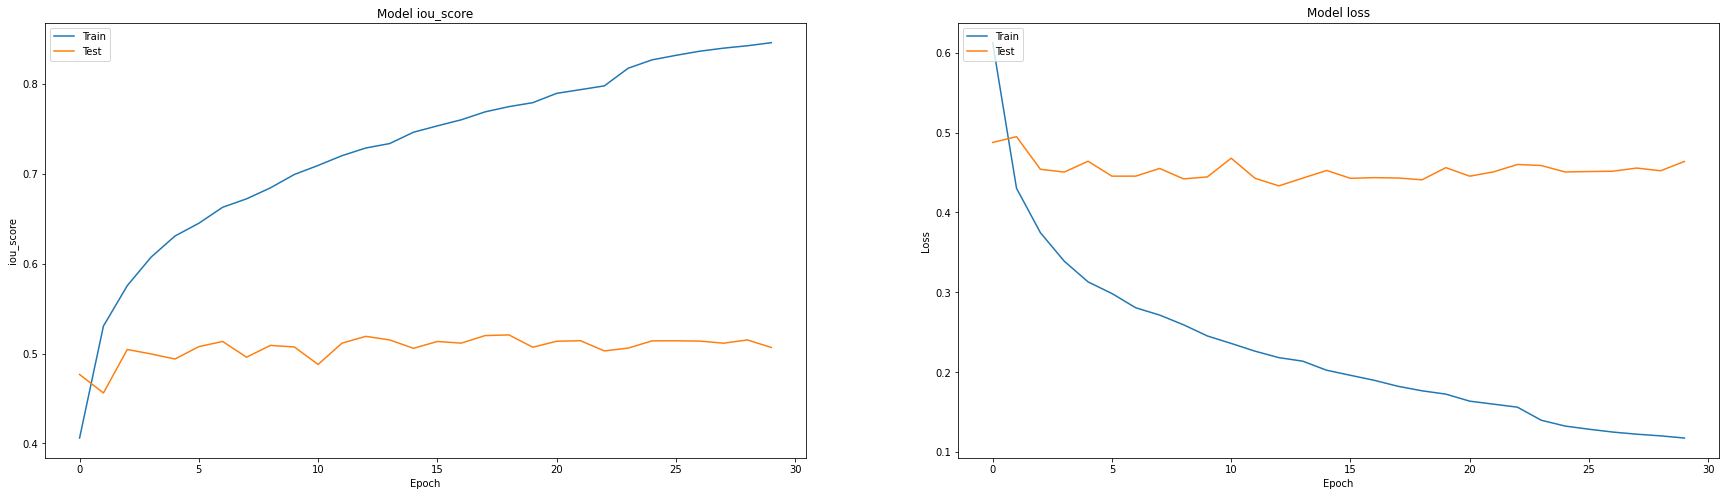

In [27]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 모델 평가

In [28]:
test_dataset = Dataset_bi(
    val_input, val_label,
    classes=CLASSES,    
#     augmentation=get_validation_augmentation(),
#         preprocessing=get_preprocessing(preprocess_input)

)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [29]:

# load best weights
model.load_weights('/content/drive/MyDrive/SIA/colab_code/lwj/lv1_R_Effb3_Unet_0001_ch.h5')


In [30]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.4333
mean iou_score: 0.51912
mean f1-score: 0.65826


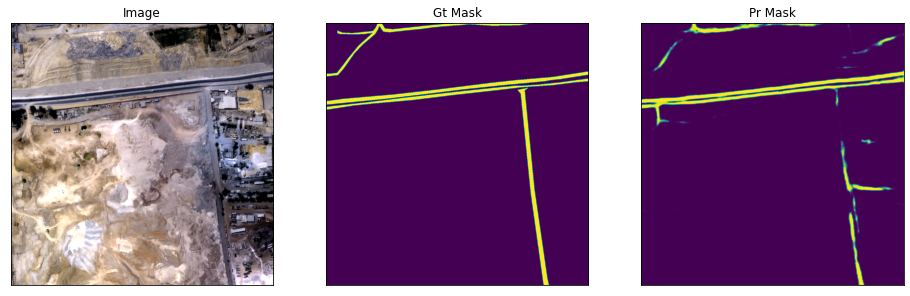

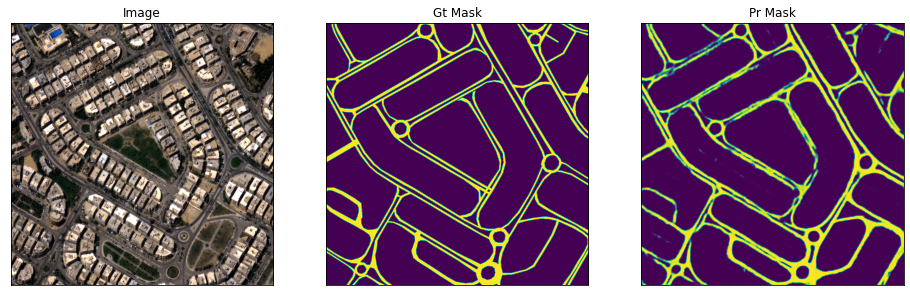

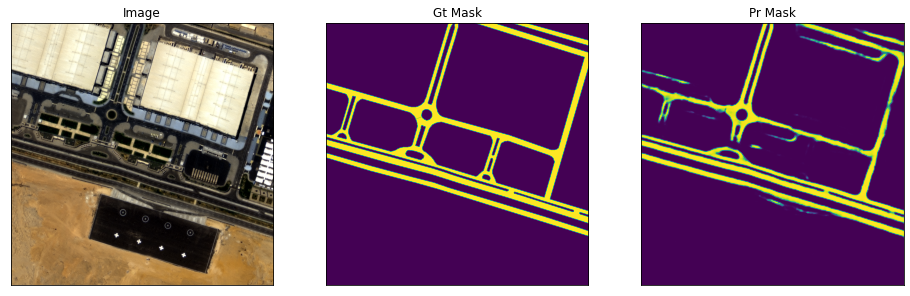

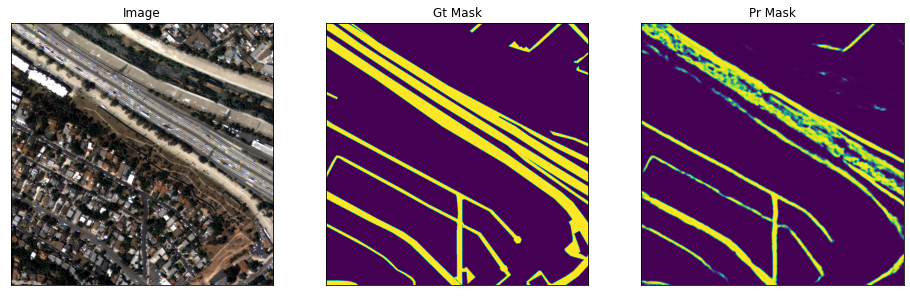

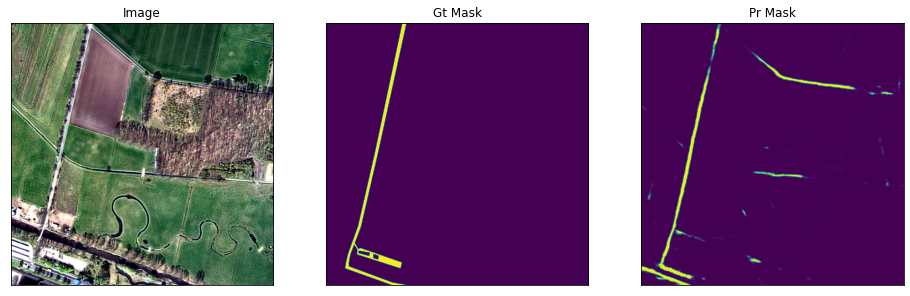

In [31]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )